In [1]:
import sys

In [2]:
sys.path.append('../')

In [379]:
import pandas as pd
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import *
from torch.optim import *
from fastai.model import *
from fastai.column_data import *
from fastai.dataloader import *
from torch.utils.data import DataLoader as torch_dl

%matplotlib inline

In [4]:
train = pd.read_feather('./data/train.feather')
test = pd.read_feather('./data/test.feather')

In [5]:
train.shape

(595212, 59)

In [6]:
train_test = pd.concat([train, test]).reset_index()

In [7]:
train_test = train_test.sample(frac=0.5)

In [8]:
train_test.reset_index(inplace=True)

### Feature Engineering

I dislike this part most, my creativity is too low for an average competition lifetime, also luck plays huge role here. Therefore I like representation learning, its also an step towards AI. Basically I removed *calc, added 1-hot to *cat features. Thats all I've done. No missing value replacement or something. This is featureset "f0" in the table. This ends up in exactly 221 dense features. With single precision floats its 1.3GB RAM (1e-9*4*221*(595212+892816)). Thanks to the public kernels (wheel of fortune eg.) that suggest to remove *calc features, I'm too blind and probably would not have figured this out by myself. I never remove features.

In [9]:
def preprocess(data):
    usecols = [False if "calc" in n else True for n in data.columns]
    data = data.loc[:,usecols]
    cat_features = [c for c in data.columns if 'cat' in c]
    add_df = data[cat_features]
    data = pd.get_dummies(data, columns=cat_features)
    data = pd.concat([data, add_df], axis= 1).drop('index', 1)
    return data

In [10]:
data = preprocess(train_test)

### Normalization (?)

Michael suggest creating uniform 0, 1 but it doesn't give gaussian??

Input normalization for gradient-based models such as neural nets is critical. For lightgbm/xgb it does not matter. The best what I found during the past and works straight of the box is "RankGauss". Its based on rank transformation. First step is to assign a linspace to the sorted features from 0..1, then apply the inverse of error function ErfInv to shape them like gaussians, then I substract the mean. Binary features are not touched with this trafo (eg. 1-hot ones). This works usually much better than standard mean/std scaler or min/max.

Generate Gaussian distributed random numbers using uniformly distributed random numbers. To convert a uniformly distributed random number  to a Gaussian distributed random number , use the transform

y = sqrt(2)*inverf(x)



In [11]:
def to_gauss(x): return np.sqrt(2)*erfinv(x) 

def normalize(data, exclude=None):
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)
        normal = to_gauss(uniform)
        normalized_col = pd.Series(index=sorted_idx, data=normal)
        data[col] = normalized_col
    return data

In [12]:
norm_data = normalize(data, exclude=['id', 'target'])

### Unsupervised Learning with Data Augmentation

Denoising autoencoders (DAE) are nice to find a better representation of the numeric data for later neural net supervised learning. One can use train+test features to build the DAE. The larger the testset, the better :) An autoencoder tries to reconstruct the inputs features. So features = targets. Linear output layer. Minimize MSE. A denoising autoencoder tries to reconstruct the noisy version of the features. It tries to find some representation of the data to better reconstruct the clean one. With modern GPUs we can put much computing power to solve this task by touching peak floating point performance with huge layers. Sometimes I saw over 300W power consumption by checking nvidia-smi. So why manually constructing 2,3,4-way interactions, use target encoding, search for count features, impute features, when a model can find something similar by itself? The critical part here is to invent the noise. In tabular datasets we cannot just flip, rotate, sheer like people are doing this in images. Adding gaussian or uniform additive / multiplicative noise is not optimal since features have different scale or a discrete set of values that some noise just didnt make sense. **I found a noise schema called "swap noise". Here I sample from the feature itself with a certain probability "inputSwapNoise" in the table above. 0.15 means 15% of features replaced by values from another row. Two different topologies are used by myself.** Deep stack, where the new features are the values of the activations on all hidden layers. Second, bottleneck, where one middle layer is used to grab the activations as new dataset. This DAE step usually blows the input dimensionality to 1k..10k range.

I recommend linear activation in the middle layer of bottleneck setup because relu truncate the values <0. Yes just concat to a long feature vector. Here for a deep stack DAE 221-1500-1500-1500-221 you get new dataset with 4500 features.

In [13]:
dropcols= ['id', 'target']
X = np.array(norm_data.drop(dropcols, 1))

In [14]:
del norm_data
del train
del test
del train_test
del data

In [15]:
def inputSwapNoise(arr, p):
    ### Takes a numpy array and swaps a row of each 
    ### feature with another value from the same column with probability p

    n, m = arr.shape
    idx = range(n)
    swap_n = round(n*p)
    for i in range(m):
        col_vals = np.random.permutation(arr[:, i])
        swap_idx = np.random.choice(idx, size= swap_n)
        arr[swap_idx, i] = np.random.choice(col_vals, size = swap_n)
    return arr

In [413]:
# separate train, val
np.random.seed(42)
n = X.shape[0]
val_ratio = 0.3
val_idxs = np.random.permutation(range(n))[:round(n*0.3)]
trn_idxs = np.random.permutation(range(n))[round(n*0.3):]

In [439]:
class AEDataset(Dataset):
    ### AutoEncoder dataset class
    ### Takes denoising function
    ### Some kind of denoising function is recommended
    ### if hidden layer sizes are smaller then input dimension
    ### since there is risk of finding identity
    
    def __init__(self, arr, denoise_func=None, p=None):
        self.x = arr.copy()
        if denoise_func: self.x_tilde = denoise_func(arr.copy(), p)
        else: self.x_tilde = arr.copy()
            
    def __len__(self): return self.x.shape[0]
    
    def __getitem__(self, idx): return torch.from_numpy(self.x_tilde[idx]).float(), torch.from_numpy(self.x[idx]).float()

In [440]:
class AEModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, torch_dl(trn_ds, batch_size=bs, shuffle=True, num_workers=1)
                         ,torch_dl(val_ds, batch_size=128, shuffle=True, num_workers=1), test_ds)
    
    @classmethod
    def from_arrays(cls, path, arr, val_idxs, trn_idxs, denoise_func, p, bs, test_ds=None):
        arr_trn = arr[val_idxs]
        arr_val = arr[trn_idxs]
        return cls(path, AEDataset(arr_trn, denoise_func, p),
                    AEDataset(arr_val, denoise_func, p), bs, test_ds=None)


In [441]:
class AutoEncoder(nn.Module):
    ### After training calling compute_activations 
    ### will allow to get activations (new features) of the input data
    
    ### You can get features at any point of training by calling
    ### get features but if couple tries will be made
    ### it's more efficient to set self.compute_activations = False
    ### after intermediate calls of get_features
    
    def __init__(self, layers, compute_activations = False):
        super().__init__()
        self.layers = layers
        self.compute_activations = compute_activations
        for i in range(len(layers)-1):
            setattr(self, f"fc{i}", nn.Linear(layers[i], layers[i + 1]))
        
    def forward(self, x):
        self.activations = []
        for i in range(len(self.layers)-1):
            dotprod = getattr(self, f"fc{i}")
            x = dotprod(x)
            if self.compute_activations:
                self.activations += [x]
        return x

    def get_activations(self, x):
        self.forward(x)
        return self.activations
        
    def get_features(self,x):
        self.compute_activations = True
        self.get_activations(x)
        features = torch.cat([act.data for act in activations], 1)
        return features

In [442]:
sample_ds = AEDataset(X, inputSwapNoise, 0.15)

In [443]:
sample_dl = torch_dl(sample_ds, batch_size=128, shuffle=True, num_workers=1)

In [444]:
data = AEModelData.from_arrays('./tmp/' ,arr=X, val_idxs=val_idxs, trn_idxs=trn_idxs, denoise_func=inputSwapNoise, p=0.15, bs=128)

In [445]:
ae = AutoEncoder([222, 300, 300, 300, 222])

In [446]:
learn = StructuredLearner(data, ae_model)

In [447]:
next(iter(data.trn_dl))

[
  0.0391  0.3403  0.4450  ...  -1.0671  1.0594 -0.9054
  0.4251 -0.3841  1.5801  ...  -0.1298 -0.2773  0.2016
 -1.4426 -0.3183 -0.1200  ...  -0.0616 -0.1612  0.4903
           ...             ⋱             ...          
  0.9345  1.2811 -0.6054  ...   0.8591 -2.0169 -0.8427
  2.0850 -0.7230  0.5294  ...   0.6027  0.7548 -0.9754
  1.2330  1.4510  1.5758  ...  -0.5525 -0.5646  0.5760
 [torch.FloatTensor of size 128x222], 
  0.0391  1.9859  0.4450  ...  -1.0671  1.0594  2.0593
  0.4251 -0.3841  1.5801  ...  -0.1298 -0.2773  0.2016
 -1.4426 -0.3183 -0.1200  ...  -0.0616 -0.1612  0.4903
           ...             ⋱             ...          
  0.9345  1.2811 -0.6054  ...   0.8591 -2.0169 -0.8427
  2.0850 -0.7230  0.4163  ...  -1.1246  0.7548 -0.9754
  1.2330  1.4510  1.5758  ...   0.3596  0.9876  0.5760
 [torch.FloatTensor of size 128x222]]

In [448]:
learn.lr_find()

A Jupyter Widget



  0%|          | 0/1744 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.19]

  0%|          | 1/1744 [00:00<03:46,  7.71it/s, loss=0.19]

  0%|          | 1/1744 [00:00<04:06,  7.06it/s, loss=0.189]

  0%|          | 1/1744 [00:00<04:22,  6.64it/s, loss=0.19] 

  0%|          | 1/1744 [00:00<04:40,  6.21it/s, loss=0.189]

  0%|          | 1/1744 [00:00<04:57,  5.85it/s, loss=0.189]

  0%|          | 1/1744 [00:00<05:13,  5.55it/s, loss=0.19] 

  0%|          | 1/1744 [00:00<05:32,  5.25it/s, loss=0.19]

  0%|          | 1/1744 [00:00<05:53,  4.93it/s, loss=0.19]

  0%|          | 1/1744 [00:00<06:24,  4.53it/s, loss=0.189]

  0%|          | 1/1744 [00:00<06:53,  4.22it/s, loss=0.189]

  1%|          | 10/1744 [00:00<00:41, 41.91it/s, loss=0.189]

  1%|          | 10/1744 [00:00<00:44, 39.00it/s, loss=0.189]

  1%|          | 10/1744 [00:00<00:47, 36.88it/s, loss=0.189]

  1%|          | 10/1744 [00:00<00:49, 35.14it/s, loss=0.189]

  1%|          | 10/1744 [00:00<00

  6%|▌         | 99/1744 [00:01<00:27, 59.98it/s, loss=0.189]

  6%|▌         | 99/1744 [00:01<00:27, 59.64it/s, loss=0.189]

  6%|▌         | 99/1744 [00:01<00:27, 59.20it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:25, 63.91it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:25, 63.48it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:25, 62.96it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:26, 62.58it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:26, 62.12it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:26, 61.59it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:26, 61.04it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:26, 60.74it/s, loss=0.189]

  6%|▌         | 107/1744 [00:01<00:27, 60.31it/s, loss=0.189]

  7%|▋         | 115/1744 [00:01<00:25, 64.52it/s, loss=0.189]

  7%|▋         | 115/1744 [00:01<00:25, 64.08it/s, loss=0.189]

  7%|▋         | 115/1744 [00:01<00:25, 63.60it/s, loss=0.189]

  7%|▋         | 115/1744 [00:01<00:25, 63.

 12%|█▏        | 206/1744 [00:03<00:24, 62.25it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:24, 62.08it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:24, 61.74it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:25, 61.46it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:25, 61.29it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:25, 61.11it/s, loss=0.189]

 12%|█▏        | 206/1744 [00:03<00:25, 60.91it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 63.03it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 62.59it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 62.29it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 61.88it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 61.55it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:24, 61.26it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:25, 61.02it/s, loss=0.189]

 12%|█▏        | 214/1744 [00:03<00:25, 60.49it/s, loss=0.189]

 13%|█▎        | 221/1744 [00:03<00:24, 

 18%|█▊        | 308/1744 [00:05<00:23, 60.22it/s, loss=0.189]

 18%|█▊        | 308/1744 [00:05<00:23, 60.06it/s, loss=0.189]

 18%|█▊        | 308/1744 [00:05<00:23, 59.91it/s, loss=0.189]

 18%|█▊        | 308/1744 [00:05<00:24, 59.77it/s, loss=0.189]

 18%|█▊        | 308/1744 [00:05<00:24, 59.65it/s, loss=0.189]

 18%|█▊        | 308/1744 [00:05<00:24, 59.53it/s, loss=0.188]

 18%|█▊        | 308/1744 [00:05<00:24, 59.40it/s, loss=0.189]

 18%|█▊        | 316/1744 [00:05<00:23, 60.92it/s, loss=0.189]

 18%|█▊        | 316/1744 [00:05<00:23, 60.78it/s, loss=0.189]

 18%|█▊        | 316/1744 [00:05<00:23, 60.63it/s, loss=0.189]

 18%|█▊        | 316/1744 [00:05<00:23, 60.49it/s, loss=0.189]

 18%|█▊        | 316/1744 [00:05<00:23, 60.36it/s, loss=0.188]

 18%|█▊        | 316/1744 [00:05<00:23, 60.21it/s, loss=0.188]

 18%|█▊        | 316/1744 [00:05<00:23, 60.06it/s, loss=0.188]

 18%|█▊        | 316/1744 [00:05<00:23, 59.90it/s, loss=0.188]

 18%|█▊        | 316/1744 [00:05<00:23, 

 24%|██▎       | 413/1744 [00:06<00:21, 62.47it/s, loss=0.187]

 24%|██▎       | 413/1744 [00:06<00:21, 62.29it/s, loss=0.187]

 24%|██▎       | 413/1744 [00:06<00:21, 62.12it/s, loss=0.187]

 24%|██▎       | 413/1744 [00:06<00:21, 61.91it/s, loss=0.187]

 24%|██▎       | 413/1744 [00:06<00:21, 61.76it/s, loss=0.188]

 24%|██▎       | 413/1744 [00:06<00:21, 61.58it/s, loss=0.188]

 24%|██▎       | 413/1744 [00:06<00:21, 61.42it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 62.43it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 62.32it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 62.16it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 62.00it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 61.84it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 61.68it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 61.54it/s, loss=0.188]

 24%|██▍       | 420/1744 [00:06<00:21, 61.36it/s, loss=0.188]

 24%|██▍       | 427/1744 [00:06<00:21, 

 29%|██▉       | 512/1744 [00:08<00:20, 60.47it/s, loss=0.188]

 29%|██▉       | 512/1744 [00:08<00:20, 60.36it/s, loss=0.188]

 29%|██▉       | 512/1744 [00:08<00:20, 60.23it/s, loss=0.187]

 29%|██▉       | 512/1744 [00:08<00:20, 60.12it/s, loss=0.187]

 29%|██▉       | 512/1744 [00:08<00:20, 60.01it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.78it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.67it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.58it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.47it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.34it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.22it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.12it/s, loss=0.187]

 30%|██▉       | 519/1744 [00:08<00:20, 60.04it/s, loss=0.187]

 30%|███       | 526/1744 [00:08<00:20, 60.78it/s, loss=0.187]

 30%|███       | 526/1744 [00:08<00:20, 60.67it/s, loss=0.187]

 30%|███       | 526/1744 [00:08<00:20, 

 35%|███▌      | 619/1744 [00:09<00:17, 62.58it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:09<00:18, 62.44it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:09<00:18, 62.32it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:09<00:18, 62.23it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:09<00:18, 62.09it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:09<00:18, 61.98it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:10<00:18, 61.88it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:10<00:18, 61.77it/s, loss=0.185]

 35%|███▌      | 619/1744 [00:10<00:18, 61.68it/s, loss=0.185]

 36%|███▌      | 627/1744 [00:10<00:17, 62.44it/s, loss=0.185]

 36%|███▌      | 627/1744 [00:10<00:17, 62.35it/s, loss=0.185]

 36%|███▌      | 627/1744 [00:10<00:17, 62.27it/s, loss=0.184]

 36%|███▌      | 627/1744 [00:10<00:17, 62.13it/s, loss=0.184]

 36%|███▌      | 627/1744 [00:10<00:18, 62.02it/s, loss=0.184]

 36%|███▌      | 627/1744 [00:10<00:18, 61.93it/s, loss=0.184]

 36%|███▌      | 627/1744 [00:10<00:18, 

 41%|████▏     | 720/1744 [00:11<00:16, 62.78it/s, loss=0.18]

 41%|████▏     | 720/1744 [00:11<00:16, 62.66it/s, loss=0.18]

 41%|████▏     | 720/1744 [00:11<00:16, 62.58it/s, loss=0.18]

 41%|████▏     | 720/1744 [00:11<00:16, 62.50it/s, loss=0.18]

 41%|████▏     | 720/1744 [00:11<00:16, 62.43it/s, loss=0.18]

 42%|████▏     | 727/1744 [00:11<00:16, 63.03it/s, loss=0.18]

 42%|████▏     | 727/1744 [00:11<00:16, 62.95it/s, loss=0.18]

 42%|████▏     | 727/1744 [00:11<00:16, 62.87it/s, loss=0.18]

 42%|████▏     | 727/1744 [00:11<00:16, 62.77it/s, loss=0.18]

 42%|████▏     | 727/1744 [00:11<00:16, 62.67it/s, loss=0.179]

 42%|████▏     | 727/1744 [00:11<00:16, 62.56it/s, loss=0.179]

 42%|████▏     | 727/1744 [00:11<00:16, 62.47it/s, loss=0.179]

 42%|████▏     | 727/1744 [00:11<00:16, 62.36it/s, loss=0.179]

 42%|████▏     | 734/1744 [00:11<00:16, 62.90it/s, loss=0.179]

 42%|████▏     | 734/1744 [00:11<00:16, 62.81it/s, loss=0.179]

 42%|████▏     | 734/1744 [00:11<00:16, 62.72it/s

 47%|████▋     | 821/1744 [00:12<00:14, 63.65it/s, loss=0.17]

 47%|████▋     | 821/1744 [00:12<00:14, 63.58it/s, loss=0.17]

 47%|████▋     | 821/1744 [00:12<00:14, 63.53it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 64.21it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 64.14it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 64.09it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 64.03it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 63.99it/s, loss=0.169]

 48%|████▊     | 830/1744 [00:12<00:14, 63.90it/s, loss=0.168]

 48%|████▊     | 830/1744 [00:13<00:14, 63.77it/s, loss=0.168]

 48%|████▊     | 830/1744 [00:13<00:14, 63.70it/s, loss=0.168]

 48%|████▊     | 830/1744 [00:13<00:14, 63.66it/s, loss=0.168]

 48%|████▊     | 838/1744 [00:13<00:14, 64.27it/s, loss=0.168]

 48%|████▊     | 838/1744 [00:13<00:14, 64.22it/s, loss=0.168]

 48%|████▊     | 838/1744 [00:13<00:14, 64.18it/s, loss=0.168]

 48%|████▊     | 838/1744 [00:13<00:14, 64

 53%|█████▎    | 930/1744 [00:14<00:12, 64.57it/s, loss=0.15]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.51it/s, loss=0.15]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.45it/s, loss=0.149]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.41it/s, loss=0.149]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.36it/s, loss=0.149]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.30it/s, loss=0.149]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.26it/s, loss=0.148]

 53%|█████▎    | 930/1744 [00:14<00:12, 64.18it/s, loss=0.148]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.69it/s, loss=0.148]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.62it/s, loss=0.148]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.55it/s, loss=0.148]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.48it/s, loss=0.148]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.41it/s, loss=0.147]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.34it/s, loss=0.147]

 54%|█████▍    | 938/1744 [00:14<00:12, 64.29it/s, loss=0.146]

 54%|█████▍    | 938/1744 [00:14<00:12, 64

 59%|█████▉    | 1030/1744 [00:16<00:11, 64.14it/s, loss=0.127]

 59%|█████▉    | 1030/1744 [00:16<00:11, 64.06it/s, loss=0.127]

 59%|█████▉    | 1030/1744 [00:16<00:11, 63.99it/s, loss=0.127]

 59%|█████▉    | 1030/1744 [00:16<00:11, 63.90it/s, loss=0.127]

 59%|█████▉    | 1030/1744 [00:16<00:11, 63.85it/s, loss=0.127]

 59%|█████▉    | 1037/1744 [00:16<00:11, 64.26it/s, loss=0.127]

 59%|█████▉    | 1037/1744 [00:16<00:11, 64.20it/s, loss=0.126]

 59%|█████▉    | 1037/1744 [00:16<00:11, 64.15it/s, loss=0.126]

 59%|█████▉    | 1037/1744 [00:16<00:11, 64.09it/s, loss=0.126]

 59%|█████▉    | 1037/1744 [00:16<00:11, 64.03it/s, loss=0.126]

 59%|█████▉    | 1037/1744 [00:16<00:11, 63.97it/s, loss=0.125]

 59%|█████▉    | 1037/1744 [00:16<00:11, 63.93it/s, loss=0.125]

 59%|█████▉    | 1037/1744 [00:16<00:11, 63.89it/s, loss=0.125]

 59%|█████▉    | 1037/1744 [00:16<00:11, 63.85it/s, loss=0.125]

 60%|█████▉    | 1045/1744 [00:16<00:10, 64.34it/s, loss=0.125]

 60%|█████▉    | 1045/174

 65%|██████▍   | 1128/1744 [00:17<00:09, 64.64it/s, loss=0.0989]

 65%|██████▍   | 1128/1744 [00:17<00:09, 64.59it/s, loss=0.0986]

 65%|██████▌   | 1137/1744 [00:17<00:09, 65.09it/s, loss=0.0986]

 65%|██████▌   | 1137/1744 [00:17<00:09, 65.05it/s, loss=0.0982]

 65%|██████▌   | 1137/1744 [00:17<00:09, 65.02it/s, loss=0.0979]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.98it/s, loss=0.0975]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.93it/s, loss=0.0971]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.90it/s, loss=0.0968]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.84it/s, loss=0.0964]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.80it/s, loss=0.0961]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.76it/s, loss=0.0958]

 65%|██████▌   | 1137/1744 [00:17<00:09, 64.71it/s, loss=0.0954]

 66%|██████▌   | 1146/1744 [00:17<00:09, 65.22it/s, loss=0.0954]

 66%|██████▌   | 1146/1744 [00:17<00:09, 65.17it/s, loss=0.0951]

 66%|██████▌   | 1146/1744 [00:17<00:09, 65.13it/s, loss=0.0947]

 66%|█████

 71%|███████   | 1236/1744 [00:18<00:07, 66.19it/s, loss=0.0695]

 71%|███████   | 1236/1744 [00:18<00:07, 66.16it/s, loss=0.0692]

 71%|███████   | 1236/1744 [00:18<00:07, 66.07it/s, loss=0.069] 

 71%|███████   | 1236/1744 [00:18<00:07, 66.03it/s, loss=0.0686]

 71%|███████   | 1236/1744 [00:18<00:07, 65.98it/s, loss=0.0683]

 71%|███████   | 1236/1744 [00:18<00:07, 65.93it/s, loss=0.0681]

 71%|███████   | 1236/1744 [00:18<00:07, 65.89it/s, loss=0.0679]

 71%|███████   | 1236/1744 [00:18<00:07, 65.83it/s, loss=0.0676]

 71%|███████   | 1236/1744 [00:18<00:07, 65.79it/s, loss=0.0674]

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.24it/s, loss=0.0674]

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.21it/s, loss=0.0673]

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.17it/s, loss=0.067] 

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.14it/s, loss=0.0667]

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.11it/s, loss=0.0665]

 71%|███████▏  | 1245/1744 [00:18<00:07, 66.07it/s, loss=0.0663]

 71%|█████

 77%|███████▋  | 1335/1744 [00:19<00:06, 67.20it/s, loss=0.0495]

 77%|███████▋  | 1335/1744 [00:19<00:06, 67.17it/s, loss=0.0493]

 77%|███████▋  | 1335/1744 [00:19<00:06, 67.12it/s, loss=0.0492]

 77%|███████▋  | 1335/1744 [00:19<00:06, 67.08it/s, loss=0.0491]

 77%|███████▋  | 1335/1744 [00:19<00:06, 67.04it/s, loss=0.049] 

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.49it/s, loss=0.049]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.44it/s, loss=0.0488]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.41it/s, loss=0.0487]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.37it/s, loss=0.0486]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.34it/s, loss=0.0485]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.31it/s, loss=0.0484]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.27it/s, loss=0.0483]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.24it/s, loss=0.0482]

 77%|███████▋  | 1344/1744 [00:19<00:05, 67.21it/s, loss=0.0481]

 77%|███████▋  | 1344/1744 [00:20<00:05, 67.15it/s, loss=0.048] 

 78%|██████

 83%|████████▎ | 1440/1744 [00:21<00:04, 68.09it/s, loss=0.04]  

 83%|████████▎ | 1440/1744 [00:21<00:04, 68.05it/s, loss=0.04]

 83%|████████▎ | 1440/1744 [00:21<00:04, 68.02it/s, loss=0.0399]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.99it/s, loss=0.0399]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.96it/s, loss=0.0398]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.91it/s, loss=0.0398]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.86it/s, loss=0.0397]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.81it/s, loss=0.0397]

 83%|████████▎ | 1440/1744 [00:21<00:04, 67.76it/s, loss=0.0396]

 83%|████████▎ | 1449/1744 [00:21<00:04, 68.17it/s, loss=0.0396]

 83%|████████▎ | 1449/1744 [00:21<00:04, 68.12it/s, loss=0.0395]

 83%|████████▎ | 1449/1744 [00:21<00:04, 68.08it/s, loss=0.0394]

 83%|████████▎ | 1449/1744 [00:21<00:04, 68.04it/s, loss=0.0393]

 83%|████████▎ | 1449/1744 [00:21<00:04, 68.00it/s, loss=0.0393]

 83%|████████▎ | 1449/1744 [00:21<00:04, 67.97it/s, loss=0.0392]

 83%|███████

 88%|████████▊ | 1537/1744 [00:22<00:03, 68.47it/s, loss=0.0358]

 88%|████████▊ | 1537/1744 [00:22<00:03, 68.44it/s, loss=0.0357]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.83it/s, loss=0.0357]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.78it/s, loss=0.0357]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.73it/s, loss=0.0356]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.68it/s, loss=0.0356]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.63it/s, loss=0.0355]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.60it/s, loss=0.0355]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.56it/s, loss=0.0355]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.52it/s, loss=0.0355]

 89%|████████▊ | 1546/1744 [00:22<00:02, 68.48it/s, loss=0.0355]

 89%|████████▉ | 1554/1744 [00:22<00:02, 68.83it/s, loss=0.0355]

 89%|████████▉ | 1554/1744 [00:22<00:02, 68.79it/s, loss=0.0354]

 89%|████████▉ | 1554/1744 [00:22<00:02, 68.76it/s, loss=0.0353]

 89%|████████▉ | 1554/1744 [00:22<00:02, 68.73it/s, loss=0.0354]

 89%|█████

 94%|█████████▍| 1642/1744 [00:23<00:01, 69.13it/s, loss=0.0351]

 94%|█████████▍| 1642/1744 [00:23<00:01, 69.10it/s, loss=0.0352]

 94%|█████████▍| 1642/1744 [00:23<00:01, 69.07it/s, loss=0.0352]

 94%|█████████▍| 1642/1744 [00:23<00:01, 69.04it/s, loss=0.0353]

 94%|█████████▍| 1642/1744 [00:23<00:01, 69.02it/s, loss=0.0353]

 94%|█████████▍| 1642/1744 [00:23<00:01, 68.99it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.40it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.37it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.35it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.31it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.29it/s, loss=0.0353]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.27it/s, loss=0.0354]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.24it/s, loss=0.0354]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.22it/s, loss=0.0354]

 95%|█████████▍| 1652/1744 [00:23<00:01, 69.19it/s, loss=0.0354]

 95%|█████

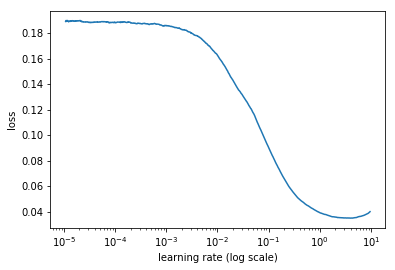

In [450]:
learn.sched.plot()

In [453]:
learn.opt_fn

<function fastai.core.SGD_Momentum.<locals>.<lambda>>

In [454]:
learn.crit

<function torch.nn.functional.mse_loss>

In [455]:
lr = 0.01
wds = 1e-4
learn.fit(lr, 1)

A Jupyter Widget



  0%|          | 0/1744 [00:00<?, ?it/s]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.186]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.188]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.189]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.19] 

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.191]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.19] 

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.19]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.189]

  0%|          | 0/1744 [00:00<?, ?it/s, loss=0.19] 

  1%|          | 9/1744 [00:00<00:20, 82.64it/s, loss=0.19]

  1%|          | 9/1744 [00:00<00:23, 72.68it/s, loss=0.189]

  1%|          | 9/1744 [00:00<00:25, 67.24it/s, loss=0.189]

  1%|          | 9/1744 [00:00<00:27, 62.42it/s, loss=0.189]

  1%|          | 9/1744 [00:00<00:29, 58.52it/s, loss=0.189]

  1%|          | 9/1744 [00:00<00:32, 54.02it/s, loss=0.189]

  1%|          | 9/1744 [00:00<00:34, 49.83it/s, loss=0.188]

  1%|          | 9/1744 [00:00<00:37, 

  6%|▌         | 101/1744 [00:01<00:24, 66.45it/s, loss=0.17] 

  6%|▌         | 101/1744 [00:01<00:25, 65.56it/s, loss=0.17]

  6%|▌         | 101/1744 [00:01<00:25, 64.93it/s, loss=0.17]

  6%|▋         | 109/1744 [00:01<00:23, 69.83it/s, loss=0.17]

  6%|▋         | 109/1744 [00:01<00:23, 69.15it/s, loss=0.17]

  6%|▋         | 109/1744 [00:01<00:23, 68.65it/s, loss=0.17]

  6%|▋         | 109/1744 [00:01<00:24, 68.07it/s, loss=0.17]

  6%|▋         | 109/1744 [00:01<00:24, 67.52it/s, loss=0.169]

  6%|▋         | 109/1744 [00:01<00:24, 66.86it/s, loss=0.169]

  6%|▋         | 109/1744 [00:01<00:24, 66.10it/s, loss=0.169]

  6%|▋         | 109/1744 [00:01<00:25, 65.31it/s, loss=0.168]

  7%|▋         | 116/1744 [00:01<00:23, 69.19it/s, loss=0.168]

  7%|▋         | 116/1744 [00:01<00:23, 68.54it/s, loss=0.168]

  7%|▋         | 116/1744 [00:01<00:23, 68.11it/s, loss=0.168]

  7%|▋         | 116/1744 [00:01<00:24, 67.60it/s, loss=0.167]

  7%|▋         | 116/1744 [00:01<00:24, 67.16i

 12%|█▏        | 208/1744 [00:03<00:22, 67.35it/s, loss=0.147]

 12%|█▏        | 208/1744 [00:03<00:22, 67.02it/s, loss=0.147]

 12%|█▏        | 208/1744 [00:03<00:23, 66.75it/s, loss=0.147]

 12%|█▏        | 208/1744 [00:03<00:23, 66.43it/s, loss=0.147]

 12%|█▏        | 208/1744 [00:03<00:23, 66.17it/s, loss=0.146]

 12%|█▏        | 208/1744 [00:03<00:23, 65.82it/s, loss=0.146]

 12%|█▏        | 215/1744 [00:03<00:22, 67.90it/s, loss=0.146]

 12%|█▏        | 215/1744 [00:03<00:22, 67.72it/s, loss=0.146]

 12%|█▏        | 215/1744 [00:03<00:22, 67.55it/s, loss=0.146]

 12%|█▏        | 215/1744 [00:03<00:22, 67.41it/s, loss=0.146]

 12%|█▏        | 215/1744 [00:03<00:22, 67.23it/s, loss=0.145]

 12%|█▏        | 215/1744 [00:03<00:22, 67.09it/s, loss=0.145]

 12%|█▏        | 215/1744 [00:03<00:22, 66.75it/s, loss=0.145]

 12%|█▏        | 215/1744 [00:03<00:23, 66.45it/s, loss=0.145]

 12%|█▏        | 215/1744 [00:03<00:23, 66.20it/s, loss=0.145]

 12%|█▏        | 215/1744 [00:03<00:23, 

 18%|█▊        | 314/1744 [00:04<00:20, 70.15it/s, loss=0.133]

 18%|█▊        | 314/1744 [00:04<00:20, 70.00it/s, loss=0.133]

 18%|█▊        | 314/1744 [00:04<00:20, 69.75it/s, loss=0.133]

 18%|█▊        | 314/1744 [00:04<00:20, 69.59it/s, loss=0.133]

 18%|█▊        | 314/1744 [00:04<00:20, 69.45it/s, loss=0.133]

 18%|█▊        | 314/1744 [00:04<00:20, 69.10it/s, loss=0.132]

 18%|█▊        | 314/1744 [00:04<00:20, 68.92it/s, loss=0.132]

 18%|█▊        | 314/1744 [00:04<00:20, 68.69it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 70.40it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 70.17it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 69.98it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 69.80it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 69.46it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 69.20it/s, loss=0.132]

 18%|█▊        | 322/1744 [00:04<00:20, 68.96it/s, loss=0.131]

 18%|█▊        | 322/1744 [00:04<00:20, 

 24%|██▎       | 413/1744 [00:06<00:20, 65.96it/s, loss=0.124]

 24%|██▎       | 413/1744 [00:06<00:20, 65.78it/s, loss=0.124]

 24%|██▎       | 413/1744 [00:06<00:20, 65.56it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:19, 66.48it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:19, 66.34it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 66.21it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 66.03it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 65.86it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 65.72it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 65.63it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 65.53it/s, loss=0.124]

 24%|██▍       | 419/1744 [00:06<00:20, 65.43it/s, loss=0.123]

 24%|██▍       | 427/1744 [00:06<00:19, 66.65it/s, loss=0.123]

 24%|██▍       | 427/1744 [00:06<00:19, 66.53it/s, loss=0.123]

 24%|██▍       | 427/1744 [00:06<00:19, 66.45it/s, loss=0.123]

 24%|██▍       | 427/1744 [00:06<00:19, 

 30%|██▉       | 515/1744 [00:07<00:18, 66.00it/s, loss=0.116]

 30%|██▉       | 515/1744 [00:07<00:18, 65.82it/s, loss=0.116]

 30%|██▉       | 522/1744 [00:07<00:18, 66.67it/s, loss=0.116]

 30%|██▉       | 522/1744 [00:07<00:18, 66.53it/s, loss=0.116]

 30%|██▉       | 522/1744 [00:07<00:18, 66.44it/s, loss=0.116]

 30%|██▉       | 522/1744 [00:07<00:18, 66.36it/s, loss=0.116]

 30%|██▉       | 522/1744 [00:07<00:18, 66.26it/s, loss=0.115]

 30%|██▉       | 522/1744 [00:07<00:18, 66.10it/s, loss=0.115]

 30%|██▉       | 522/1744 [00:07<00:18, 65.97it/s, loss=0.115]

 30%|██▉       | 522/1744 [00:07<00:18, 65.84it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 66.71it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 66.61it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 66.51it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 66.39it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 66.22it/s, loss=0.115]

 30%|███       | 529/1744 [00:07<00:18, 

 35%|███▌      | 619/1744 [00:09<00:16, 67.68it/s, loss=0.108]

 35%|███▌      | 619/1744 [00:09<00:16, 67.56it/s, loss=0.108]

 36%|███▌      | 627/1744 [00:09<00:16, 68.38it/s, loss=0.108]

 36%|███▌      | 627/1744 [00:09<00:16, 68.27it/s, loss=0.108]

 36%|███▌      | 627/1744 [00:09<00:16, 68.17it/s, loss=0.108]

 36%|███▌      | 627/1744 [00:09<00:16, 68.05it/s, loss=0.108]

 36%|███▌      | 627/1744 [00:09<00:16, 67.97it/s, loss=0.107]

 36%|███▌      | 627/1744 [00:09<00:16, 67.85it/s, loss=0.107]

 36%|███▌      | 627/1744 [00:09<00:16, 67.77it/s, loss=0.107]

 36%|███▌      | 627/1744 [00:09<00:16, 67.66it/s, loss=0.107]

 36%|███▌      | 627/1744 [00:09<00:16, 67.58it/s, loss=0.107]

 36%|███▋      | 635/1744 [00:09<00:16, 68.43it/s, loss=0.107]

 36%|███▋      | 635/1744 [00:09<00:16, 68.33it/s, loss=0.107]

 36%|███▋      | 635/1744 [00:09<00:16, 68.21it/s, loss=0.107]

 36%|███▋      | 635/1744 [00:09<00:16, 68.11it/s, loss=0.107]

 36%|███▋      | 635/1744 [00:09<00:16, 

 41%|████▏     | 723/1744 [00:10<00:15, 67.27it/s, loss=0.101]

 41%|████▏     | 723/1744 [00:10<00:15, 67.17it/s, loss=0.101]

 42%|████▏     | 731/1744 [00:10<00:14, 67.90it/s, loss=0.101]

 42%|████▏     | 731/1744 [00:10<00:14, 67.76it/s, loss=0.101]

 42%|████▏     | 731/1744 [00:10<00:14, 67.66it/s, loss=0.101]

 42%|████▏     | 731/1744 [00:10<00:14, 67.58it/s, loss=0.101]

 42%|████▏     | 731/1744 [00:10<00:15, 67.49it/s, loss=0.1]  

 42%|████▏     | 731/1744 [00:10<00:15, 67.41it/s, loss=0.1]

 42%|████▏     | 731/1744 [00:10<00:15, 67.34it/s, loss=0.1]

 42%|████▏     | 731/1744 [00:10<00:15, 67.27it/s, loss=0.1]

 42%|████▏     | 738/1744 [00:10<00:14, 67.90it/s, loss=0.1]

 42%|████▏     | 738/1744 [00:10<00:14, 67.83it/s, loss=0.1]

 42%|████▏     | 738/1744 [00:10<00:14, 67.75it/s, loss=0.1]

 42%|████▏     | 738/1744 [00:10<00:14, 67.66it/s, loss=0.0998]

 42%|████▏     | 738/1744 [00:10<00:14, 67.58it/s, loss=0.0997]

 42%|████▏     | 738/1744 [00:10<00:14, 67.50it/s,

 47%|████▋     | 828/1744 [00:12<00:13, 66.71it/s, loss=0.0946]

 47%|████▋     | 828/1744 [00:12<00:13, 66.65it/s, loss=0.0946]

 47%|████▋     | 828/1744 [00:12<00:13, 66.57it/s, loss=0.0945]

 47%|████▋     | 828/1744 [00:12<00:13, 66.50it/s, loss=0.0945]

 47%|████▋     | 828/1744 [00:12<00:13, 66.43it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.98it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.91it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.83it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.77it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.70it/s, loss=0.0945]

 48%|████▊     | 835/1744 [00:12<00:13, 66.64it/s, loss=0.0944]

 48%|████▊     | 835/1744 [00:12<00:13, 66.58it/s, loss=0.0944]

 48%|████▊     | 835/1744 [00:12<00:13, 66.51it/s, loss=0.0943]

 48%|████▊     | 835/1744 [00:12<00:13, 66.45it/s, loss=0.0943]

 48%|████▊     | 843/1744 [00:12<00:13, 67.07it/s, loss=0.0943]

 48%|████▊     | 843/1744

 53%|█████▎    | 926/1744 [00:15<00:13, 61.50it/s, loss=0.0895]

 53%|█████▎    | 926/1744 [00:15<00:13, 61.46it/s, loss=0.0895]

 53%|█████▎    | 926/1744 [00:15<00:13, 61.42it/s, loss=0.0895]

 53%|█████▎    | 926/1744 [00:15<00:13, 61.37it/s, loss=0.0895]

 53%|█████▎    | 926/1744 [00:15<00:13, 61.28it/s, loss=0.0893]

 53%|█████▎    | 926/1744 [00:15<00:13, 61.21it/s, loss=0.0892]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.66it/s, loss=0.0892]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.61it/s, loss=0.0892]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.56it/s, loss=0.0892]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.52it/s, loss=0.0891]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.46it/s, loss=0.0891]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.40it/s, loss=0.0891]

 53%|█████▎    | 933/1744 [00:15<00:13, 61.34it/s, loss=0.089] 

 53%|█████▎    | 933/1744 [00:15<00:13, 61.20it/s, loss=0.089]

 54%|█████▍    | 940/1744 [00:15<00:13, 61.64it/s, loss=0.089]

 54%|█████▍    | 940/1744 [

 59%|█████▊    | 1022/1744 [00:16<00:11, 61.27it/s, loss=0.0846]

 59%|█████▊    | 1022/1744 [00:16<00:11, 61.23it/s, loss=0.0845]

 59%|█████▊    | 1022/1744 [00:16<00:11, 61.16it/s, loss=0.0845]

 59%|█████▊    | 1022/1744 [00:16<00:11, 61.09it/s, loss=0.0845]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.62it/s, loss=0.0845]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.54it/s, loss=0.0845]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.50it/s, loss=0.0844]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.44it/s, loss=0.0844]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.39it/s, loss=0.0843]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.35it/s, loss=0.0842]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.31it/s, loss=0.0842]

 59%|█████▉    | 1031/1744 [00:16<00:11, 61.26it/s, loss=0.0841]

 60%|█████▉    | 1038/1744 [00:16<00:11, 61.66it/s, loss=0.0841]

 60%|█████▉    | 1038/1744 [00:16<00:11, 61.62it/s, loss=0.0841]

 60%|█████▉    | 1038/1744 [00:16<00:11, 61.51it/s, loss=0.0841]

 60%|█████

 64%|██████▍   | 1124/1744 [00:18<00:10, 61.17it/s, loss=0.0808]

 64%|██████▍   | 1124/1744 [00:18<00:10, 61.14it/s, loss=0.0807]

 65%|██████▍   | 1130/1744 [00:18<00:09, 61.46it/s, loss=0.0807]

 65%|██████▍   | 1130/1744 [00:18<00:09, 61.43it/s, loss=0.0806]

 65%|██████▍   | 1130/1744 [00:18<00:10, 61.23it/s, loss=0.0806]

 65%|██████▍   | 1130/1744 [00:18<00:10, 61.00it/s, loss=0.0805]

 65%|██████▍   | 1130/1744 [00:18<00:10, 60.91it/s, loss=0.0805]

 65%|██████▍   | 1130/1744 [00:18<00:10, 60.67it/s, loss=0.0804]

 65%|██████▌   | 1135/1744 [00:18<00:09, 60.94it/s, loss=0.0804]

 65%|██████▌   | 1135/1744 [00:18<00:10, 60.83it/s, loss=0.0804]

 65%|██████▌   | 1135/1744 [00:18<00:10, 60.74it/s, loss=0.0803]

 65%|██████▌   | 1135/1744 [00:18<00:10, 60.67it/s, loss=0.0803]

 65%|██████▌   | 1135/1744 [00:18<00:10, 60.54it/s, loss=0.0803]

 65%|██████▌   | 1135/1744 [00:18<00:10, 60.39it/s, loss=0.0803]

 65%|██████▌   | 1140/1744 [00:18<00:09, 60.65it/s, loss=0.0803]

 65%|█████

 70%|███████   | 1224/1744 [00:20<00:08, 59.14it/s, loss=0.077]

 70%|███████   | 1224/1744 [00:20<00:08, 59.10it/s, loss=0.0769]

 70%|███████   | 1224/1744 [00:20<00:08, 59.07it/s, loss=0.0769]

 70%|███████   | 1224/1744 [00:20<00:08, 59.02it/s, loss=0.077] 

 70%|███████   | 1224/1744 [00:20<00:08, 59.00it/s, loss=0.077]

 70%|███████   | 1224/1744 [00:20<00:08, 58.96it/s, loss=0.0769]

 70%|███████   | 1224/1744 [00:20<00:08, 58.92it/s, loss=0.0769]

 70%|███████   | 1224/1744 [00:20<00:08, 58.90it/s, loss=0.0769]

 70%|███████   | 1224/1744 [00:20<00:08, 58.86it/s, loss=0.0768]

 70%|███████   | 1224/1744 [00:20<00:08, 58.83it/s, loss=0.0769]

 71%|███████   | 1233/1744 [00:20<00:08, 59.26it/s, loss=0.0769]

 71%|███████   | 1233/1744 [00:20<00:08, 59.22it/s, loss=0.0768]

 71%|███████   | 1233/1744 [00:20<00:08, 59.18it/s, loss=0.0768]

 71%|███████   | 1233/1744 [00:20<00:08, 59.15it/s, loss=0.0768]

 71%|███████   | 1233/1744 [00:20<00:08, 59.12it/s, loss=0.0768]

 71%|███████

 76%|███████▌  | 1319/1744 [00:22<00:07, 59.62it/s, loss=0.0741]

 76%|███████▌  | 1319/1744 [00:22<00:07, 59.59it/s, loss=0.0741]

 76%|███████▌  | 1319/1744 [00:22<00:07, 59.56it/s, loss=0.0741]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.96it/s, loss=0.0741]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.94it/s, loss=0.074] 

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.90it/s, loss=0.074]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.88it/s, loss=0.074]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.83it/s, loss=0.0739]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.79it/s, loss=0.0739]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.76it/s, loss=0.0738]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.71it/s, loss=0.0738]

 76%|███████▌  | 1328/1744 [00:22<00:06, 59.67it/s, loss=0.0737]

 77%|███████▋  | 1336/1744 [00:22<00:06, 60.01it/s, loss=0.0737]

 77%|███████▋  | 1336/1744 [00:22<00:06, 59.98it/s, loss=0.0737]

 77%|███████▋  | 1336/1744 [00:22<00:06, 59.94it/s, loss=0.0737]

 77%|███████

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.78it/s, loss=0.0711]

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.74it/s, loss=0.071] 

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.71it/s, loss=0.071]

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.66it/s, loss=0.071]

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.63it/s, loss=0.071]

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.59it/s, loss=0.071]

 82%|████████▏ | 1424/1744 [00:23<00:05, 60.56it/s, loss=0.071]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.94it/s, loss=0.071]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.91it/s, loss=0.0709]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.88it/s, loss=0.0709]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.85it/s, loss=0.071] 

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.82it/s, loss=0.0709]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.79it/s, loss=0.071] 

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.76it/s, loss=0.071]

 82%|████████▏ | 1433/1744 [00:23<00:05, 60.73it/s, loss=0.0709]

 82%|████████▏ | 

 87%|████████▋ | 1523/1744 [00:24<00:03, 60.97it/s, loss=0.069]

 87%|████████▋ | 1523/1744 [00:25<00:03, 60.91it/s, loss=0.0689]

 87%|████████▋ | 1523/1744 [00:25<00:03, 60.87it/s, loss=0.069] 

 87%|████████▋ | 1523/1744 [00:25<00:03, 60.83it/s, loss=0.069]

 88%|████████▊ | 1530/1744 [00:25<00:03, 61.09it/s, loss=0.069]

 88%|████████▊ | 1530/1744 [00:25<00:03, 61.05it/s, loss=0.0689]

 88%|████████▊ | 1530/1744 [00:25<00:03, 61.01it/s, loss=0.069] 

 88%|████████▊ | 1530/1744 [00:25<00:03, 60.97it/s, loss=0.0689]

 88%|████████▊ | 1530/1744 [00:25<00:03, 60.94it/s, loss=0.0688]

 88%|████████▊ | 1530/1744 [00:25<00:03, 60.83it/s, loss=0.0688]

 88%|████████▊ | 1530/1744 [00:25<00:03, 60.78it/s, loss=0.0688]

 88%|████████▊ | 1530/1744 [00:25<00:03, 60.73it/s, loss=0.0688]

 88%|████████▊ | 1537/1744 [00:25<00:03, 61.00it/s, loss=0.0688]

 88%|████████▊ | 1537/1744 [00:25<00:03, 60.96it/s, loss=0.0687]

 88%|████████▊ | 1537/1744 [00:25<00:03, 60.93it/s, loss=0.0686]

 88%|████████

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.82it/s, loss=0.0665]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.79it/s, loss=0.0664]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.76it/s, loss=0.0663]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.73it/s, loss=0.0664]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.70it/s, loss=0.0663]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.67it/s, loss=0.0663]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.65it/s, loss=0.0663]

 93%|█████████▎| 1626/1744 [00:26<00:01, 61.61it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.95it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.91it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.88it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.84it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.82it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.80it/s, loss=0.0663]

 94%|█████████▍| 1635/1744 [00:26<00:01, 61.77it/s, loss=0.0663]

 94%|█████

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.85it/s, loss=0.0647]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.82it/s, loss=0.0647]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.79it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.77it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.73it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.70it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.68it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.66it/s, loss=0.0646]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.63it/s, loss=0.0645]

 99%|█████████▉| 1730/1744 [00:27<00:00, 62.61it/s, loss=0.0645]

100%|█████████▉| 1739/1744 [00:27<00:00, 62.93it/s, loss=0.0645]

100%|█████████▉| 1739/1744 [00:27<00:00, 62.90it/s, loss=0.0644]

100%|█████████▉| 1739/1744 [00:27<00:00, 62.87it/s, loss=0.0644]

100%|█████████▉| 1739/1744 [00:27<00:00, 62.83it/s, loss=0.0643]

100%|█████████▉| 1739/1744 [00:27<00:00, 62.81it/s, loss=0.0643]

100%|█████

In [456]:
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.04803  0.04765]                                     



In [457]:
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.04301  0.04295]                                     



In [458]:
learn.lr_find()

A Jupyter Widget

[ 0.       0.04064  0.05021]                                    



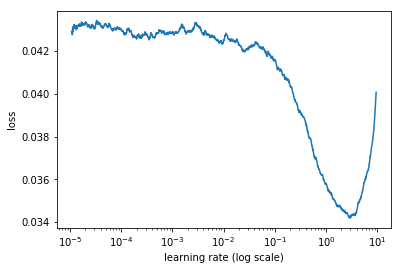

In [459]:
learn.sched.plot()

In [460]:
lr = 0.05
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.03578  0.0357 ]                                     



In [461]:
lr = 0.05
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.03369  0.03372]                                    



In [462]:
lr = 0.05
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.03285  0.03287]                                    



In [466]:
next(iter(ae.parameters()))

Parameter containing:
1.00000e-02 *
-2.2928 -4.8191 -6.2890  ...   4.1326  5.6328 -0.0123
 5.5249 -0.6513  5.1792  ...   2.0702 -4.2579 -3.3544
 1.5093  1.1863  3.2085  ...   1.9016  4.9584 -0.4375
          ...             ⋱             ...          
-2.0018  3.1131 -3.3354  ...  -5.6999  3.0091 -2.3885
-5.2683 -5.3870 -2.7114  ...   4.6578 -1.1151  3.5731
-0.4651  6.5104 -2.1673  ...  -1.6273 -2.6240 -5.1079
[torch.FloatTensor of size 300x222]

In [467]:
lr = 0.05
learn.fit(lr, 1, wds=wds)

A Jupyter Widget

[ 0.       0.03247  0.03241]                                     



In [484]:
next(iter(ae_model.model.parameters()))

Parameter containing:
 4.7442e-02 -4.1738e-02 -3.5968e-02  ...  -1.1113e-02  1.6781e-02 -5.9290e-04
-2.9780e-02  5.6289e-02  1.5839e-02  ...  -2.3853e-02 -2.1117e-02  3.3087e-02
 1.7162e-02 -5.8618e-02  5.5707e-03  ...  -2.0544e-02 -4.9601e-02 -2.1198e-02
                ...                   ⋱                   ...                
-1.0272e-01  3.5959e-02  1.8075e-03  ...  -3.8725e-02 -6.4345e-02 -2.2569e-02
 6.4216e-03  4.9504e-02  6.1717e-02  ...  -1.8503e-02 -1.0521e-02 -9.7265e-03
 6.7842e-02 -2.2561e-02  6.9076e-02  ...  -5.2335e-03  4.2812e-02 -9.0641e-02
[torch.FloatTensor of size 300x222]

In [493]:
activations = ae_model.model.get_features(Variable(torch.FloatTensor(sample_ds.x)))

In [494]:
activations[:10]


-2.3271e-01 -3.8290e-01  1.0843e-01  ...  -2.0960e+00  1.5111e+00  4.1242e-01
 1.4389e-02 -2.4281e-01 -1.9223e-01  ...   2.5632e-01 -1.6720e-01  4.6129e-01
-2.4925e-01  4.8246e-01  2.2139e-02  ...   1.7301e-01  6.6125e-01  3.5058e-01
                ...                   ⋱                   ...                
-3.3899e-02 -9.2360e-02 -2.9474e-01  ...   2.1841e-01 -1.7882e-01  4.4258e-01
-1.3616e-01 -2.9690e-02  1.3968e-01  ...   3.1014e-01 -1.2210e-01  2.3558e-01
-1.9790e-01  2.8558e-01  1.9640e-02  ...   9.9782e-01  6.5255e-01  2.1487e-01
[torch.FloatTensor of size 10x1122]